---
title: "Terse Alternating Least Squares Implementation"
pubDate: 2022-08-07T02:53:16+02:00
description: "This lab teaches the math and engineering behind Alternating Least Squares: how to derive the least-squares formula, why alternation is needed, and how to implement it efficiently. Includes ready-to-use code snippets and a real-world example showing the method's limits."
category: "lab"
math: true
tags:
    - python
    - machine-learning
---

Recommendation systems algorithms behind familiar features like Netflix movie suggestions or Amazon product recommendations. These systems rely on _collaborative filtering_, which uses the past behavior of many users to infer preferences. Matrix factorization methods such as ALS are among the most effective techniques for this task.

## The Matrix Factorization Problem

In recommendation systems, we typically have:

- A set of users
- A set of items
- A sparse matrix of known ratings or interactions

Let's call this sparse matrix $R$ where $R_{ui}$ represents user $u$'s interaction with item $i$. Most entries in $R$ are missing. 

The basic ALS formulation is particularly useful in **implicit feedback settings**, where zeros are assumed to be meaningful rather than missing data. This approach is commonly used in **implicit recommendation systems**, such as collaborative filtering for user interactions (e.g., clicks, purchases, or views).  
However, in **explicit feedback settings** (e.g., movie ratings), missing values should be properly handled to avoid bias in factorization.

The goal of matrix factorization is to approximate $R$ as the product of two lower-dimensional matrices:

$$ 
R \approx U \cdot V^T 
$$

Where:
$$
\begin{aligned}
& U \text{ is a user-feature matrix of shape } [\text{num\_users}, \text{num\_features}] \\
& V \text{ is an item-feature matrix of shape } [\text{num\_items}, \text{num\_features}]
\end{aligned}
$$


Each row of $ U $ represents a **user’s latent preference vector**, which encodes how much they tend to interact with certain hidden factors. Likewise, each row of $ V $ represents an **item’s latent feature vector**, which captures how strongly an item aligns with those same factors. These vectors are learned such that their interactions best approximate the observed data in $ R $, revealing patterns in user behavior and item similarities.

### **Solving a Non-Convex Optimization Problem**

To reiterate, we aim to approximate $R$ using two lower-rank matrices, capturing the latent structure in the data:

$$
\min_{U, V} \sum_{(u,i) \in \text{observed}} (R_{ui} - U_u V_i^T)^2
$$

This is a **non-convex optimization problem** because both $ U $ and $ V $ are unknown and multiply each other. **Simultaneously** optimizing both matrices would require solving a problem with multiple local minima, making direct gradient-based optimization difficult.

### **Why ALS Works**
Instead of solving for both $ U $ and $ V $ at once, **Alternating Least Squares (ALS)** breaks the problem into two **convex subproblems**:

1. **Fix $ V $ and solve for $ U $**  
2. **Fix $ U $ and solve for $ V $**  

Since each of these steps is a standard **least squares problem**, they have a closed-form solution that can be computed efficiently.


## Setting Up Our Example

Let's create a small example with synthetic data to demonstrate ALS.

In [1]:
import numpy as np
np.set_printoptions(precision=3)
np.random.seed(42)

In [2]:
users = 50
items = 30
features = 10

The following matrix $R$ represents our sparse user-item interaction matrix. For simplicity, we're using binary values (0 or 1) to indicate whether a user interacted with an item:

In [3]:
R = np.random.choice([0, 1], size= [users,items], p=[.9, .1])
R

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(50, 30))

Here we initialize our user and item latent factor matrices with random values from a normal distribution. In a real application, we might use different initialization strategies:

In [4]:
U = np.random.normal(0,1, [users, features])
V = np.random.normal(0,1, [items, features])

### **Understanding the ALS Updates**

Matrix factorization assumes we approximate $R$ using two lower-rank matrices $U$ and $V$:

$$
U V^T = R \quad \Leftrightarrow \quad V U^T = R^T
$$

To find optimal values for these matrices, ALS alternates between solving for $U$ with $V$ fixed and vice versa. This alternating approach makes each sub-problem convex, guaranteeing a unique global minimum at each step.

Let's illustrate this clearly by deriving the update rule explicitly for one row of $U$:

- **For each row $U[i]$:**
  
  $$
  U[i] V = R[i]
  $$

  This corresponds to solving the least squares problem[^1]:

  $$
  \min_{U[i]} \sum_{j}\left(R_{ij} - U[i] V[j]^T\right)^2
  $$

  Expanding the squared term gives:

  $$
  \sum_{j}\left(R_{ij}^2 - 2 R_{ij} U[i] V[j]^T + (U[i] V[j]^T)^2\right)
  $$

  Since we fixed $V$, this function is convex in $U[i]$, and the minimum is found by setting the derivative to zero:

  $$
  \sum_j\left(-2 R_{ij} V[j] + 2 U[i] V[j]^T V[j]\right) = 0
  $$

  Simplifying, we have:

  $$
  U[i] \sum_j V[j]^T V[j] = \sum_j R_{ij} V[j]
  $$

  Recognizing the matrix forms:

  $$
  V^T V = \sum_j V[j]^T V[j], \quad V^T R[i] = \sum_j R_{ij} V[j]
  $$

  we obtain the closed-form solution:

  $$
  U[i] = (V^T V)^{-1} V^T R[i]
  $$

- **For each row $V[i]$:**
  
  $$
  V[i] U = R[:, i]
  $$

  Which leads to the least squares update:

  $$
  V[i] = (U^T U)^{-1} U^T R[:, i]
  $$

Now, instead of iterating over rows, these updates can be **vectorized** for efficiency and conciseness:

- **Solving for $U$ in matrix form:**
  
  $$
  U = R V (V^T V)^{-1}
  $$

- **Solving for $V$ in matrix form:**
  
  $$
  V = R^T U (U^T U)^{-1}
  $$

### **Solving the Least Squares System with `numpy.linalg.solve`**  

The least squares updates derived above involve computing matrix inverses. However, explicitly computing the inverse (or pseudoinverse) can be numerically unstable. Instead, we solve the linear system directly using `numpy.linalg.solve`, which finds the solution \( X \) to the equation:

$$
A X = B
$$

where $A = V^T V$ and $B = V^T R^T$ (for solving $U$), or $A = U^T U$ and $B = U^T R$ (for solving $V$).

Thus, the least squares updates can be computed efficiently and with better numerical stability as:

$$
U = \text{np.linalg.solve}(V^T V, V^T R^T)^T
$$

$$
V = \text{np.linalg.solve}(U^T U, U^T R)^T
$$

We will use this formulation in the ALS implementation below.

In [5]:
# Compute initial reconstruction error
prev_score = np.linalg.norm(U @ V.T - R)

# Store errors for visualization
errors = [prev_score]

# ALS Iterations
num_iterations = 100
for iteration in range(num_iterations):
    # Without vectorization (per-row computation)
    # for i in range(U.shape[0]):
    #     U[i] = np.linalg.pinv(V.T @ V) @ V.T @ R[i]

    # Equivalent vectorized forms for solving U:
    # U = (np.linalg.pinv(V.T @ V) @ V.T @ R.T).T
    # U = R @ V @ np.linalg.pinv(V.T @ V)
    U = np.linalg.solve(V.T @ V, V.T @ R.T).T  # numerically stable solution

    # Without vectorization (per-row computation)
    # for i in range(V.shape[0]):
    #     V[i] = np.linalg.pinv(U.T @ U) @ U.T @ R[:, i]

    # Equivalent vectorized forms for solving V:
    # V = (np.linalg.pinv(U.T @ U) @ U.T @ R).T
    # V = R.T @ U @ np.linalg.pinv(U.T @ U)
    V = np.linalg.solve(U.T @ U, U.T @ R).T  # numerically stable solution

    # Compute and store error after each iteration
    errors.append(np.linalg.norm(U @ V.T - R))

# Compute final reconstruction error
final_score = errors[-1]

print(f"Initial error: {errors[0]:.4f}")
print(f"Error after 1 iteration: {errors[1]:.4f}")
print(f"Final error after {num_iterations} iterations: {final_score:.4f}")


Initial error: 120.4196
Error after 1 iteration: 8.3655
Final error after 100 iterations: 6.6819


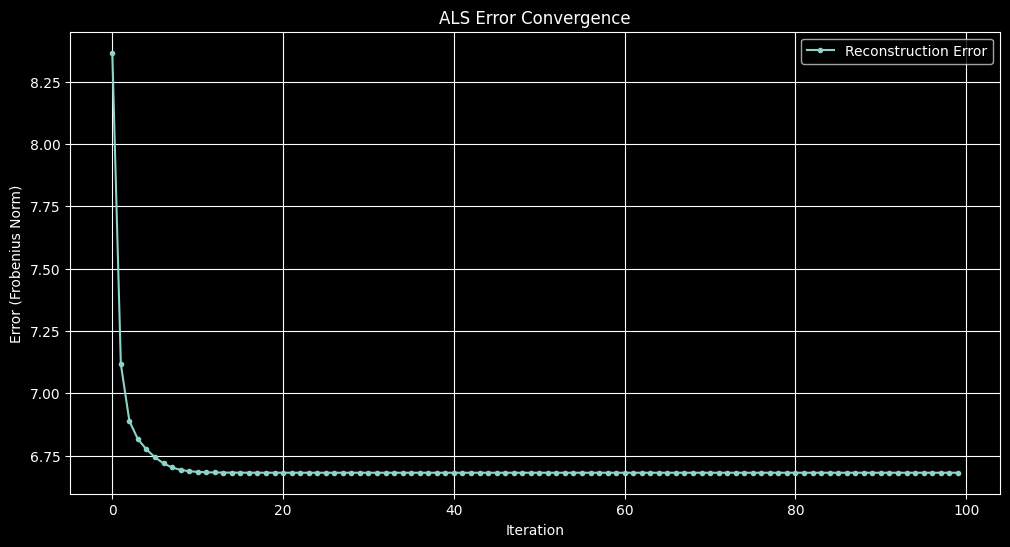

In [6]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.figure(figsize=(12, 6))
plt.plot(errors[1:], marker="o", linestyle="-", markersize=3, label="Reconstruction Error") # Exclude the first error value to better visualize the convergence process without the initial large drop.
plt.xlabel("Iteration")
plt.ylabel("Error (Frobenius Norm)")
plt.title("ALS Error Convergence")
plt.legend()
plt.grid()
plt.show()


### **Regularized ALS**

In practice, it's common to add regularization terms to ALS to prevent overfitting and improve numerical stability. Regularized ALS optimizes the following loss function:

$$
L = \sum_{m,n}(R_{mn} - U_m^T V_n)^2 + \lambda \sum_m ||U_m||^2 + \lambda \sum_n ||V_n||^2
$$

This leads to the regularized update equations:
  
$$
U = (V^T V + \lambda I)^{-1} V^T R
\quad \text{and} \quad
V = (U^T U + \lambda I)^{-1} U^T R
$$

Regularization is especially valuable when working with sparse datasets, as it helps avoid **singular matrix issues** during matrix inversion steps.


### **Weighted ALS (WALS)**

Weighted ALS generalizes ALS by assigning different importance (weights) to observed ratings. This method is particularly beneficial in explicit feedback scenarios, such as rating systems (e.g., movie ratings), where some items or users have significantly more interactions than others. By applying weights, WALS compensates for this imbalance, boosting underrepresented items and improving recommendation fairness.

WALS optimizes the following loss function:

$$
L^w = \sum_{m,n} w_{mn}(R_{mn} - U_m^T V_n)^2 + \lambda \sum_m ||U_m||^2 + \lambda \sum_n ||V_n||^2
$$

Here, each rating's squared error is scaled individually by a weight \(w_{mn}\).

#### **Choosing the weights**

Inspired by [this resource](https://cs229.stanford.edu/proj2017/final-posters/5147271.pdf)[^2], we propose a practical method for computing these weights, accounting for item popularity:

- Each weight \(w_{mn}\) is computed as a baseline plus a scaling factor dependent on how frequently the item \(n\) has been reviewed:

$$
w_{mn} = w_0 + f(c_n)
$$

- $(w_0)$ is a baseline weight, ensuring every interaction has a minimal influence.
- $ (c_n = \sum_{m} \mathbf{1}(R_{mn} > 0)) $ is the number of non-zero ratings for item \(n\), representing the item's popularity.

Two common choices for the scaling function \(f(c_n)\) are:

- **Linear (explicit) scaling**, suitable for explicit feedback datasets (such as movie ratings):

  $$
  f(c_n) = \frac{w_k}{c_n}
  $$

  Here, more popular items (higher \(c_n\)) receive lower additional weight, balancing their influence.

- **Exponential (implicit) scaling**, suitable for implicit feedback scenarios (such as clicks or views):

  $$
  f(c_n) = \left(\frac{1}{c_n}\right)^e
  $$

  This sharply decreases the influence of very popular items, controlled by the exponent \(e\).

#### **Weighted ALS Update Step**

When performing updates in WALS, the weight vector for each user or item is transformed into a diagonal matrix by multiplying with the identity matrix:

- For user factors \(U_m\):

  $$
  U_m = \left(V^T (\text{diag}(w_m)) V + \lambda I\right)^{-1} V^T (\text{diag}(w_m)) R_m
  $$

- For item factors \(V_n\):

  $$
  V_n = \left(U^T (\text{diag}(w_n)) U + \lambda I\right)^{-1} U^T (\text{diag}(w_n)) R_n
  $$

In these equations, $ \text{diag}(w_m) $ and $ \text{diag}(w_n) $ explicitly create diagonal matrices from weight vectors \(w_m\) and \(w_n\), respectively, ensuring that each interaction is weighted correctly and independently.

A complete, efficient implementation of Weighted ALS using these updates will be provided in the full code example at the end of this blog post.


### **Alternatives and Extra Resources**

While ALS and its weighted variant are effective, other optimization methods like **Stochastic Gradient Descent (SGD)** are frequently employed:

- **Stochastic Gradient Descent (SGD)** updates parameters iteratively, adjusting each user-item interaction individually. This characteristic makes SGD well-suited for **online recommendation systems**, though typically slower for large batch-processed datasets.

Notable resources and advanced readings include:

- ["Fast Matrix Factorization for Online Recommendation with Implicit Feedback"](https://arxiv.org/pdf/1708.05024)[^3], presenting efficient algorithms specifically tailored for implicit-feedback online scenarios.

These alternatives and resources are valuable considerations when adapting matrix factorization methods to diverse real-world scenarios.

## Conclusion

Alternating Least Squares is a powerful technique for matrix factorization in recommendation systems. The algorithm's key advantage is that it handles the non-convex optimization problem by alternating between convex subproblems, each of which has a closed-form solution.

While more advanced techniques like neural collaborative filtering have emerged in recent years, ALS remains relevant for its simplicity, interpretability, and effectiveness, especially for large-scale recommendation tasks.

## Full Python implementations

In [6]:
import numpy as np

# ---------- weighting utils ----------
def linear_weight_fn(c_n, w0: float = 0.1, wk: float = 1.0):
    """Per-item popularity weights; smaller extra weight for very popular items."""
    return w0 + wk / (c_n + 1e-8)

def make_mask(R: np.ndarray, zero_means_missing: bool = True) -> np.ndarray:
    """
    Build observation mask M.
    - If zero_means_missing: treat 0 as missing (implicit/binary clicks).
    - Else: any entry counts as observed (or non-NaN for float matrices).
    """
    if zero_means_missing:
        return (R > 0).astype(float)
    return (~np.isnan(R)).astype(float) if np.issubdtype(R.dtype, np.floating) else np.ones_like(R, dtype=float)

def item_weights_from_mask(M: np.ndarray, weight_fn=linear_weight_fn) -> np.ndarray:
    """Compute per-item weights from popularity (column sums of M)."""
    c_n = M.sum(axis=0)          # popularity per item
    return weight_fn(c_n)         # shape: (items,)

# ---------- metrics ----------
def observed_rmse(R_true: np.ndarray, R_pred: np.ndarray, M: np.ndarray) -> float:
    num = ((R_true - R_pred)**2 * M).sum()
    den = M.sum()
    return np.sqrt(num / max(den, 1))

def weighted_rmse(R_true: np.ndarray, R_pred: np.ndarray, w_item: np.ndarray, M: np.ndarray) -> float:
    W = M * w_item               # broadcasts over columns
    num = ((R_true - R_pred)**2 * W).sum()
    den = W.sum()
    return np.sqrt(num / max(den, 1))


In [7]:
import numpy as np

def als_with_regularization(
    R: np.ndarray,
    rank: int = 10,
    iters: int = 100,
    reg: float = 0.1,
    *,
    zero_means_missing: bool = True,
    seed: int | None = 42,
    dtype=np.float32,
):
    """
    Unweighted ALS. Zeros are treated as real observations inside the update;
    M is returned so you can ignore zeros as 'missing' in metrics.
    Returns: U, V, w_item (all ones), M
    """
    rng = np.random.default_rng(seed) if seed is not None else np.random.default_rng()
    users, items = R.shape
    I = np.eye(rank, dtype=dtype)

    U = rng.normal(0, 1, (users, rank)).astype(dtype)
    V = rng.normal(0, 1, (items, rank)).astype(dtype)
    Rt = R.astype(dtype)

    for _ in range(iters):
        Gv = V.T @ V + reg * I
        U = (np.linalg.solve(Gv, V.T @ Rt.T).T).astype(dtype)

        Gu = U.T @ U + reg * I
        V = (np.linalg.solve(Gu, U.T @ Rt).T).astype(dtype)

    M = make_mask(R, zero_means_missing=zero_means_missing)
    w_item = np.ones(items, dtype=float)
    return U, V, w_item, M

# ----- demo -----
users, items, rank = 50, 30, 10
R = np.random.default_rng(42).choice([0, 1], size=(users, items), p=[0.9, 0.1])

U, V, w_item, M = als_with_regularization(R, rank=rank, iters=100, reg=0.1, seed=42, zero_means_missing=True)
R_hat = U @ V.T

print(f"Observed RMSE (mask only): {observed_rmse(R, R_hat, M):.4f}")
print(f"Weighted RMSE (matches training): {weighted_rmse(R, R_hat, w_item, M):.4f}")
print(f"Full Frobenius Norm (incl. missing zeros): {np.linalg.norm(R - R_hat):.4f}")


Observed RMSE (mask only): 0.4026
Weighted RMSE (matches training): 0.4026
Full Frobenius Norm (incl. missing zeros): 6.9064


In [8]:
import numpy as np

def weighted_als(
    R: np.ndarray,
    rank: int = 10,
    iters: int = 100,
    reg: float = 0.1,
    *,
    weight_fn=linear_weight_fn,
    zero_means_missing: bool = True,
    seed: int | None = 42,
    dtype=np.float32,
):
    """
    Weighted ALS where observed entries are scaled by per-item weights.
    Returns: U, V, w_item, M
    """
    rng = np.random.default_rng(seed) if seed is not None else np.random.default_rng()
    users, items = R.shape
    I = np.eye(rank, dtype=dtype)

    U = rng.normal(0, 1, (users, rank)).astype(dtype)
    V = rng.normal(0, 1, (items, rank)).astype(dtype)
    Rt = R.astype(dtype)

    M = make_mask(R, zero_means_missing=zero_means_missing)     # (users, items)
    w_item = item_weights_from_mask(M, weight_fn)               # (items,)
    W = M * w_item                                              # per-entry weights

    for _ in range(iters):
        # users
        for m in range(users):
            wm = W[m]                       # (items,)
            Vw = V * wm[:, None]
            A = V.T @ Vw + reg * I
            b = (Rt[m] * wm) @ V
            U[m] = np.linalg.solve(A, b).astype(dtype)
        # items
        for n in range(items):
            wn = W[:, n]                    # (users,)
            Uw = U * wn[:, None]
            A = U.T @ Uw + reg * I
            b = (Rt[:, n] * wn) @ U
            V[n] = np.linalg.solve(A, b).astype(dtype)

    return U, V, w_item, M

# ----- demo -----
users, items, rank = 50, 30, 10
R = np.random.default_rng(42).choice([0, 1], size=(users, items), p=[0.9, 0.1])

U, V, w_item, M = weighted_als(R, rank=rank, iters=100, reg=0.1, weight_fn=linear_weight_fn, seed=42, zero_means_missing=True)
R_hat = U @ V.T

print(f"Observed RMSE (mask only): {observed_rmse(R, R_hat, M):.4f}")
print(f"Weighted RMSE (matches training): {weighted_rmse(R, R_hat, w_item, M):.4f}")
print(f"Full Frobenius Norm (incl. missing zeros): {np.linalg.norm(R - R_hat):.4f}")


Observed RMSE (mask only): 0.0925
Weighted RMSE (matches training): 0.0931
Full Frobenius Norm (incl. missing zeros): 31.8075


# Real-world example

In [23]:
# --- deps & insecure download (requested) ---
import io, time, numpy as np, pandas as pd, requests, urllib3
from functools import partial

url = "https://files.grouplens.org/datasets/movielens/ml-100k/u.data"
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
resp = requests.get(url, verify=False, timeout=30)
resp.raise_for_status()

ratings = pd.read_csv(io.BytesIO(resp.content), sep="\t",
                      names=["user_id", "item_id", "rating", "timestamp"])

# --- preprocess: zero-index, time-based 80/20 split, filter cold test users ---
ratings["user_id"] -= 1
ratings["item_id"] -= 1

ratings_sorted = ratings.sort_values("timestamp").reset_index(drop=True)
split_idx = int(len(ratings_sorted) * 0.8)
train_data, test_data = ratings_sorted[:split_idx], ratings_sorted[split_idx:]

user_rating_counts = train_data['user_id'].value_counts()
valid_users = user_rating_counts[user_rating_counts >= 10].index
test_data = test_data[test_data['user_id'].isin(valid_users)]

print(f"Train users: {train_data['user_id'].nunique()} | Train ratings: {len(train_data)}")
print(f"Test  users: {test_data['user_id'].nunique()} | Test  ratings: {len(test_data)}")

num_users = ratings.user_id.max() + 1
num_items = ratings.item_id.max() + 1

def to_matrix(df):
    R = np.zeros((num_users, num_items), dtype=np.float32)
    for r in df.itertuples(index=False):
        R[r.user_id, r.item_id] = r.rating
    return R

R_train = to_matrix(train_data)
R_test  = to_matrix(test_data)

# --- masks & popularity weights (computed **only from train**) ---
M_train = make_mask(R_train, zero_means_missing=True)
M_test  = make_mask(R_test,  zero_means_missing=True)

# default linear popularity weights; will override with partials in grid search
w_item_train_default = item_weights_from_mask(M_train, weight_fn=linear_weight_fn)

# --- baselines: unweighted ALS vs weighted ALS (default linear weights) ---
rank, iters, reg = 10, 100, 1.5

t0 = time.time()
U_reg, V_reg, _, _ = als_with_regularization(
    R_train, rank=rank, iters=iters, reg=reg, seed=42, zero_means_missing=True
)
time_reg = time.time() - t0

t0 = time.time()
U_wlin, V_wlin, w_item_used, _ = weighted_als(
    R_train, rank=rank, iters=iters, reg=reg,
    weight_fn=linear_weight_fn, seed=42, zero_means_missing=True
)
time_wlin = time.time() - t0

Rhat_reg  = U_reg @ V_reg.T
Rhat_wlin = U_wlin @ V_wlin.T

# --- evaluation policy:
# For model selection: weighted RMSE with **train-derived** item weights, masking on the eval split.
# Also report plain observed RMSE for comparability.
train_weighted_rmse_reg  = weighted_rmse(R_train, Rhat_reg,  w_item_train_default, M_train)
test_weighted_rmse_reg   = weighted_rmse(R_test,  Rhat_reg,  w_item_train_default, M_test)

train_weighted_rmse_wlin = weighted_rmse(R_train, Rhat_wlin, w_item_train_default, M_train)
test_weighted_rmse_wlin  = weighted_rmse(R_test,  Rhat_wlin, w_item_train_default, M_test)

train_obs_rmse_reg  = observed_rmse(R_train, Rhat_reg,  M_train)
test_obs_rmse_reg   = observed_rmse(R_test,  Rhat_reg,  M_test)

train_obs_rmse_wlin = observed_rmse(R_train, Rhat_wlin, M_train)
test_obs_rmse_wlin  = observed_rmse(R_test,  Rhat_wlin, M_test)

results_baselines = pd.DataFrame({
    "Method": ["ALS (unweighted)", "ALS (weighted linear default)"],
    "Train RMSE (weighted)": [train_weighted_rmse_reg,  train_weighted_rmse_wlin],
    "Test RMSE (weighted)":  [test_weighted_rmse_reg,   test_weighted_rmse_wlin],
    "Train RMSE (observed)": [train_obs_rmse_reg,       train_obs_rmse_wlin],
    "Test RMSE (observed)":  [test_obs_rmse_reg,        test_obs_rmse_wlin],
    "Time (s)": [time_reg, time_wlin],
})
print("\n--- Baseline Results ---")
print(results_baselines)

# --- global mean & item-bias baselines (observed RMSE only; included for context) ---
global_mean = R_train[M_train > 0].mean() if M_train.sum() > 0 else 0.0
R_global = np.full_like(R_train, global_mean, dtype=np.float32)

item_sums   = (R_train * M_train).sum(axis=0)
item_counts = M_train.sum(axis=0)
item_biases = np.divide(item_sums - item_counts * global_mean, item_counts + 1e-8)
R_itembias  = np.tile(global_mean, (num_users, num_items)).astype(np.float32) + item_biases

gm_train = observed_rmse(R_train, R_global,   M_train)
gm_test  = observed_rmse(R_test,  R_global,   M_test)
ib_train = observed_rmse(R_train, R_itembias, M_train)
ib_test  = observed_rmse(R_test,  R_itembias, M_test)

results_context = pd.DataFrame({
    "Method": ["Global Mean", "Item Bias"],
    "Train RMSE (observed)": [gm_train, ib_train],
    "Test RMSE (observed)":  [gm_test,  ib_test],
})
print("\n--- Context Baselines (observed RMSE) ---")
print(results_context)

# --- grid search over **linear** weight parameters (train weights; eval policy honored) ---
print("\nGrid search: Linear popularity weights (train-derived)")
grid_rows = []
for w0 in [0.5, 1.0, 1.5]:
    for wk in [0.05, 0.1, 0.2]:
        wf = partial(linear_weight_fn, w0=w0, wk=wk)
        # train model with these weights
        start = time.time()
        U_g, V_g, _, _ = weighted_als(
            R_train, rank=rank, iters=iters, reg=reg,
            weight_fn=wf, seed=42, zero_means_missing=True
        )
        elapsed = time.time() - start
        Rhat_g = U_g @ V_g.T

        # compute **train-derived weights** for scoring
        w_item_train = item_weights_from_mask(M_train, weight_fn=wf)
        test_wrmse = weighted_rmse(R_test, Rhat_g, w_item_train, M_test)
        train_wrmse = weighted_rmse(R_train, Rhat_g, w_item_train, M_train)
        test_obs = observed_rmse(R_test, Rhat_g, M_test)

        grid_rows.append({
            "w0": w0, "wk": wk,
            "Train RMSE (weighted)": train_wrmse,
            "Test RMSE (weighted)":  test_wrmse,
            "Test RMSE (observed)":  test_obs,
            "Time (s)": elapsed
        })
        print(f"w0={w0:.2f}, wk={wk:.2f} | test(weighted)={test_wrmse:.4f}, test(observed)={test_obs:.4f}, time={elapsed:.2f}s")

lin_df = pd.DataFrame(grid_rows)
best_idx = lin_df["Test RMSE (weighted)"].idxmin()
best_lin = lin_df.loc[best_idx]
print("\nBest Linear Weights by Test RMSE (weighted, train-derived):")
print(best_lin)


Train users: 751 | Train ratings: 80000
Test  users: 107 | Test  ratings: 2875

--- Baseline Results ---
                          Method  Train RMSE (weighted)  Test RMSE (weighted)  \
0               ALS (unweighted)               2.334016              3.395304   
1  ALS (weighted linear default)               0.800927              3.395304   

   Train RMSE (observed)  Test RMSE (observed)   Time (s)  
0               2.276690              3.122586   0.108951  
1               0.803892              1.201897  12.054622  

--- Context Baselines (observed RMSE) ---
        Method  Train RMSE (observed)  Test RMSE (observed)
0  Global Mean               1.127381              1.128035
1    Item Bias               0.995549              1.029807

Grid search: Linear popularity weights (train-derived)
w0=0.50, wk=0.05 | test(weighted)=3.3953, test(observed)=1.1765, time=11.87s
w0=0.50, wk=0.10 | test(weighted)=3.3953, test(observed)=1.1763, time=12.13s
w0=0.50, wk=0.20 | test(weighted)=3.39

# Implicit feedback performance

In [22]:
# --- Exponential popularity weight fn (new) ---
def exponential_weight_fn(c_n, w0: float = 1.0, e: float = 0.1):
    # w_i = w0 + (1 / count_i)^e ; keeps weights finite and softer than linear
    return w0 + np.power(1.0 / (c_n + 1e-8), e)

# --- Signed prefs ---
def to_signed_matrix(df):
    R = np.zeros((num_users, num_items), dtype=np.float32)
    for row in df.itertuples():
        R[row.user_id, row.item_id] = 1.0 if row.rating >= 4 else -1.0
    return R

R_train = to_signed_matrix(train_data)
R_test  = to_signed_matrix(test_data)

# deterministic sign with tie-break to +1
def sign_with_tiebreak(x):
    s = np.sign(x)
    s[s == 0] = 1.0
    return s

def compute_sign_accuracy(R_true, R_pred):
    mask = (R_true != 0)
    preds = sign_with_tiebreak(R_pred)
    return np.mean((preds[mask] == R_true[mask]).astype(np.float32))

# ---- Train models (100 iters for all) ----
rank, iters, reg = 10, 100, 10.0

start = time.time()
U_reg, V_reg, _, _ = als_with_regularization(
    R_train, rank=rank, iters=iters, reg=reg,
    seed=42, zero_means_missing=True
)
time_reg = time.time() - start

start = time.time()
U_wals_lin, V_wals_lin, _, _ = weighted_als(
    R_train, rank=rank, iters=iters, reg=reg,
    weight_fn=linear_weight_fn, seed=42, zero_means_missing=True
)
time_wals_lin = time.time() - start

start = time.time()
U_wals_exp, V_wals_exp, _, _ = weighted_als(
    R_train, rank=rank, iters=iters, reg=reg,
    weight_fn=exponential_weight_fn, seed=42, zero_means_missing=True
)
time_wals_exp = time.time() - start

# ---- Baselines (sign) ----
# Global-mean sign with tie-break
nonzero = (R_train != 0)
gm = R_train[nonzero].mean() if nonzero.any() else 0.0
gm_sign = 1.0 if gm == 0 else float(np.sign(gm))

baseline_train_acc = np.mean((R_train[nonzero] == gm_sign).astype(np.float32))
nonzero_test = (R_test != 0)
baseline_test_acc  = np.mean((R_test[nonzero_test] == gm_sign).astype(np.float32))

# Item-bias score then sign
item_sums   = R_train.sum(axis=0)
item_counts = (R_train != 0).sum(axis=0)
item_biases = (item_sums - item_counts * gm) / (item_counts + 1e-8)
R_itembias  = np.tile(gm, (num_users, num_items)).astype(np.float32) + item_biases
R_itembias_signed = sign_with_tiebreak(R_itembias)

itembias_train_acc = compute_sign_accuracy(R_train, R_itembias_signed)
itembias_test_acc  = compute_sign_accuracy(R_test,  R_itembias_signed)

# ---- Collect results ----
methods = [
    "ALS Regularized",
    "Weighted ALS (Linear)",
    "Weighted ALS (Exponential)",
    "Global Mean Baseline",
    "Item Bias Baseline",
]

train_acc = [
    compute_sign_accuracy(R_train, U_reg @ V_reg.T),
    compute_sign_accuracy(R_train, U_wals_lin @ V_wals_lin.T),
    compute_sign_accuracy(R_train, U_wals_exp @ V_wals_exp.T),
    baseline_train_acc,
    itembias_train_acc,
]

test_acc = [
    compute_sign_accuracy(R_test, U_reg @ V_reg.T),
    compute_sign_accuracy(R_test, U_wals_lin @ V_wals_lin.T),
    compute_sign_accuracy(R_test, U_wals_exp @ V_wals_exp.T),
    baseline_test_acc,
    itembias_test_acc,
]

times = [time_reg, time_wals_lin, time_wals_exp, 0.0, 0.0]

results = pd.DataFrame({
    "Method": methods,
    "Train Accuracy": train_acc,
    "Test Accuracy": test_acc,
    "Time (s)": times,
})
print(results)


                       Method  Train Accuracy  Test Accuracy   Time (s)
0             ALS Regularized        0.788575       0.654957   0.108554
1       Weighted ALS (Linear)        0.550900       0.546087  14.665292
2  Weighted ALS (Exponential)        0.550900       0.546087  17.718337
3        Global Mean Baseline        0.550900       0.546087   0.000000
4          Item Bias Baseline        0.677163       0.670261   0.000000


# Comparing with surprise SVD

In [20]:
%%bash
uv run --python 3.11 --no-project \
  --with surprise --with "numpy<2" --with pandas --with requests - <<'EOF'
from surprise import SVD, Dataset, Reader, accuracy
import pandas as pd
import urllib3, requests, io

# Insecure download (ignore cert)
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
url = "https://files.grouplens.org/datasets/movielens/ml-100k/u.data"
resp = requests.get(url, verify=False, timeout=30)
resp.raise_for_status()
ratings = pd.read_csv(io.BytesIO(resp.content), sep="\t",
                      names=["user_id", "item_id", "rating", "timestamp"])

# Zero-index
ratings["user_id"] -= 1
ratings["item_id"] -= 1

# Time split
ratings_sorted = ratings.sort_values("timestamp").reset_index(drop=True)
split_idx = int(len(ratings_sorted) * 0.8)
train_data = ratings_sorted[:split_idx].copy()
test_data  = ratings_sorted[split_idx:].copy()

# Keep only test users with >=10 ratings in train (don't shrink train)
user_counts = train_data['user_id'].value_counts()
valid_users = set(user_counts[user_counts >= 10].index)
test_data = test_data[test_data['user_id'].isin(valid_users)]

# Ensure test items exist in train (avoid Surprise cold-start)
train_items = set(train_data['item_id'].unique())
test_data = test_data[test_data['item_id'].isin(train_items)]

print(f"Train users: {train_data['user_id'].nunique()}, Ratings: {len(train_data)}")
print(f"Test  users: {test_data['user_id'].nunique()}, Ratings: {len(test_data)}")

# Surprise setup
reader = Reader(rating_scale=(1, 5))
train_dataset = Dataset.load_from_df(train_data[['user_id','item_id','rating']], reader)
trainset = train_dataset.build_full_trainset()
testset = list(test_data[['user_id','item_id','rating']].itertuples(index=False, name=None))

# Train SVD (biased MF)
algo = SVD()
algo.fit(trainset)

# Evaluate observed RMSE
pred_test  = algo.test(testset)
test_rmse  = accuracy.rmse(pred_test, verbose=False)

pred_train = algo.test(trainset.build_testset())
train_rmse = accuracy.rmse(pred_train, verbose=False)

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test  RMSE: {test_rmse:.4f}")
EOF


Train users: 751, Ratings: 80000
Test  users: 105, Ratings: 2786
Train RMSE: 0.6786
Test  RMSE: 0.9774


In [19]:
%%bash
uv run --python 3.11 --no-project \
  --with surprise --with "numpy<2" --with pandas --with requests - <<'EOF'
from surprise import SVD, Dataset, Reader
import pandas as pd
import urllib3, requests, io

# Insecure download (ignore cert)
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
url = "https://files.grouplens.org/datasets/movielens/ml-100k/u.data"
resp = requests.get(url, verify=False, timeout=30)
resp.raise_for_status()
ratings = pd.read_csv(io.BytesIO(resp.content), sep="\t",
                      names=["user_id","item_id","rating","timestamp"])

# Zero-index
ratings["user_id"] -= 1
ratings["item_id"] -= 1

# Time split
ratings_sorted = ratings.sort_values("timestamp").reset_index(drop=True)
split_idx = int(len(ratings_sorted) * 0.8)
train_data = ratings_sorted[:split_idx].copy()
test_data  = ratings_sorted[split_idx:].copy()

# Filter test users with >=10 ratings in TRAIN (do NOT shrink train)
user_counts = train_data['user_id'].value_counts()
valid_users = set(user_counts[user_counts >= 10].index)
test_data = test_data[test_data['user_id'].isin(valid_users)]

# Ensure test items exist in train (avoid cold-start)
train_items = set(train_data['item_id'].unique())
test_data = test_data[test_data['item_id'].isin(train_items)]

# Binarize ratings to ±1
train_data = train_data.copy()
test_data  = test_data.copy()
train_data["rating"] = (train_data["rating"] >= 4).astype(int).replace({0:-1, 1:1})
test_data["rating"]  = (test_data["rating"]  >= 4).astype(int).replace({0:-1, 1:1})

print(f"Train users: {train_data['user_id'].nunique()}, Ratings: {len(train_data)}")
print(f"Test  users: {test_data['user_id'].nunique()}, Ratings: {len(test_data)}")

# Surprise setup (scale is -1..1 after binarization)
reader = Reader(rating_scale=(-1, 1))
train_dataset = Dataset.load_from_df(train_data[['user_id','item_id','rating']], reader)
trainset = train_dataset.build_full_trainset()
testset  = list(test_data[['user_id','item_id','rating']].itertuples(index=False, name=None))

# Train SVD (biased MF) — regression on [-1,1]
algo = SVD(n_factors=20, n_epochs=10, lr_all=0.005, reg_all=0.02)
algo.fit(trainset)

# Sign-accuracy (tie at 0 => positive)
def sign_accuracy(preds):
    correct = 0
    for p in preds:
        pred_label = 1 if p.est >= 0 else -1
        correct += (pred_label == p.r_ui)
    return correct / len(preds) if preds else 0.0

pred_test  = algo.test(testset)
test_acc   = sign_accuracy(pred_test)

pred_train = algo.test(trainset.build_testset())
train_acc  = sign_accuracy(pred_train)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test  Accuracy: {test_acc:.4f}")
EOF


Train users: 751, Ratings: 80000
Test  users: 105, Ratings: 2786
Train Accuracy: 0.7398
Test  Accuracy: 0.6831


# Real-World Conclusion

In a realistic temporal split, **ALS performed well in implicit feedback**, with fast convergence and solid accuracy. On explicit feedback, **Weighted ALS (WALS)** outperformed plain ALS but still failed to beat strong baselines like item bias or Surprise’s SVD. **WALS is also much slower in Python**, due to per-user/item weighted matrix solves. Despite that, ALS remains a strong, efficient choice, especially for large-scale or implicit recommendation tasks.

*Note*: after some analysis, our ALS implementations did not include user/item bias terms, which are known to capture a large portion of the signal in explicit rating data. Models like Surprise’s SVD include these biases, so part of their performance edge comes from that. Will come back with better implementation.

[^1]: https://mathworld.wolfram.com/NormalEquation.html
[^2]: Stanford CS229 Project. "Weighted Alternating Least Squares." Accessed from: [https://cs229.stanford.edu/proj2017/final-posters/5147271.pdf](https://cs229.stanford.edu/proj2017/final-posters/5147271.pdf)

[^3]: He, Xiangnan, et al. (2017). "Fast Matrix Factorization for Online Recommendation with Implicit Feedback." *Proceedings of SIGIR*. [https://arxiv.org/pdf/1708.05024](https://arxiv.org/pdf/1708.05024)